<div style="text-align: center;">
    <h1> <font style="bold"> Trabajo Práctico Integrador </font></h1>
    <h2><font style="bold">Visión por Computadora II - CEIA </font></h2>
    <h3><font style="bold">Abril Noguera - Pedro Barrera - Ezequiel Caamaño</font></h3>
    <h4><font style="bold">Modelo Baseline</font></h4>
</div>

# Detección Automatizada de Cáncer de Pulmón mediante Visión por Computadora

## Modelo Baseline

### Diseño

Para construir un modelo base con buen rendimiento inicial y poco esfuerzo de desarrollo, se optó por usar una arquitectura preentrenada con **transfer learning**.

- **Modelo preentrenado**: `ResNet18`, ya entrenado en ImageNet
  - Arquitectura liviana y eficiente
  - Buen balance entre precisión y velocidad
- **Técnica**: Transfer learning con mínimo fine-tuning
  - Se congelan los pesos de todas las capas convolucionales
  - Solo se entrena el **head** (la capa final de clasificación)
- **Salida del modelo**: Clasificación multiclase con 4 clases:
  - `adenocarcinoma`, `large.cell.carcinoma`, `squamous.cell.carcinoma`, `normal`

Esta configuración busca obtener una primera línea de base rápida, sin necesidad de entrenar el modelo desde cero.

### Importación de librerias

In [36]:
import os
import torch
import torch.nn as nn
from torch.optim import Adam
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import accuracy_score, recall_score, confusion_matrix, f1_score, precision_recall_fscore_support, ConfusionMatrixDisplay
import numpy as np
from torchvision.models import resnet18, ResNet18_Weights
import pandas as pd

from dotenv import load_dotenv

# Cargar las variables desde el archivo .env
load_dotenv()

True

In [2]:
# Download latest version
import kagglehub
path = kagglehub.dataset_download("mohamedhanyyy/chest-ctscan-images")

print("Path to dataset files:", path)
data_dir = os.path.join(path, "Data")

c:\Users\pedro\TP_VPC2\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Path to dataset files: C:\Users\pedro\.cache\kagglehub\datasets\mohamedhanyyy\chest-ctscan-images\versions\1


### Configuración

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
path = os.getenv("DATASET_PATH")
data_dir = os.path.join(path, "Data")
num_classes = 4
batch_size = 32
num_epochs = 5
learning_rate = 1e-3

In [15]:
print(f"Using device: {device}")

Using device: cuda


In [16]:
# Transformaciones para los datos
weights = ResNet18_Weights.DEFAULT
transform = weights.transforms()

print(transform)

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)


In [17]:
# Datasets y DataLoaders
train_ds = datasets.ImageFolder(os.path.join(data_dir, "train"), transform=transform)
valid_ds = datasets.ImageFolder(os.path.join(data_dir, "valid"), transform=transform)
test_ds  = datasets.ImageFolder(os.path.join(data_dir, "test"), transform=transform)

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_ds, batch_size=batch_size)
test_loader  = DataLoader(test_ds, batch_size=batch_size)

In [18]:
# Modelo
model = models.resnet18(pretrained=True)

# Congelar capas convolucionales
for param in model.parameters():
    param.requires_grad = False

# Reemplazar la capa final
model.fc = nn.Linear(model.fc.in_features, num_classes)
model = model.to(device)

print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

c:\Users\pedro\TP_VPC2\.venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\pedro\TP_VPC2\.venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


### Entrenamiento

In [ ]:
def calcular_merticas_(all_labels, all_preds):
    acc = accuracy_score(all_labels, all_preds)

    # Sensibilidad es recall de la clase positiva
    sensibilidad = recall_score(all_labels, all_preds, pos_label=1)

    # Especificidad es recall de la clase negativa
    especificidad = recall_score(all_labels, all_preds, pos_label=0)

    f1 = f1_score(all_labels, all_preds, pos_label=1)

    return {
        "Accuracy": acc,
        "Sensibilidad": sensibilidad,
        "Especificidad": especificidad,
        "F1": f1
    }

In [32]:
def metricas(modelo, dataloader, class_names, zero_division=0):
    modelo.eval()
    all_preds, all_labels = [], []

    with torch.no_grad():
        for x, y in dataloader:
            x, y = x.to(device), y.to(device)
            outputs = modelo(x)
            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y.cpu().numpy())

    overall_accuracy = accuracy_score(all_labels, all_preds)

    precision, recall, f1, _ = precision_recall_fscore_support(
        all_labels,
        all_preds,
        average=None,
        zero_division=zero_division,
    )

    cm = confusion_matrix(all_labels, all_preds)
    total_samples = cm.sum()

    per_class_rows = []
    for idx, name in enumerate(class_names):
        tp = cm[idx, idx]
        fp = cm[:, idx].sum() - tp
        fn = cm[idx, :].sum() - tp
        tn = total_samples - (tp + fp + fn)

        specificity = tn / (tn + fp) if (tn + fp) > 0 else zero_division
        class_accuracy = (tp + tn) / total_samples if total_samples > 0 else 0.0

        per_class_rows.append(
            {
                "clase": name,
                "accuracy": float(class_accuracy),
                "precision": float(precision[idx]),
                "sensibilidad": float(recall[idx]),
                "especificidad": float(specificity),
                "f1": float(f1[idx]),
            }
        )

    metrics_df = pd.DataFrame(per_class_rows).set_index("clase")

    overall_f1 = f1_score(
        all_labels,
        all_preds,
        average="macro",
        zero_division=zero_division,
    )

    globales = {
        "accuracy_global": float(overall_accuracy),
        "f1_global": float(overall_f1),
    }

    return metrics_df, globales, cm

In [29]:
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.fc.parameters(), lr=learning_rate)

def evaluar_acc(modelo, dataloader):
    modelo.eval()
    all_preds, all_labels = [], []

    with torch.no_grad():
        for x, y in dataloader:
            x, y = x.to(device), y.to(device)
            outputs = modelo(x)
            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y.cpu().numpy())

    acc = accuracy_score(all_labels, all_preds)
    return acc
    

print("Entrenamiento:")

for epoch in range(num_epochs):
    model.train()
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Evaluación por epoch
    train_acc = evaluar_acc(model, train_loader)
    val_acc = evaluar_acc(model, valid_loader)
    print(f"Epoch {epoch+1}/{num_epochs} | Train Acc: {train_acc:.2f} | Val Acc: {val_acc:.2f}")


Entrenamiento:
Epoch 1/5 | Train Acc: 0.81 | Val Acc: 0.68
Epoch 2/5 | Train Acc: 0.85 | Val Acc: 0.67
Epoch 3/5 | Train Acc: 0.85 | Val Acc: 0.64
Epoch 4/5 | Train Acc: 0.85 | Val Acc: 0.65
Epoch 5/5 | Train Acc: 0.85 | Val Acc: 0.65


### Evaluacion

In [49]:
import matplotlib.pyplot as plt
def plot_cm(cm, classes, normalize = 'true'):
    if normalize is None:
        cm_to_plot = cm
        values_format = "d"
    elif normalize == "true":
        cm_to_plot = cm.astype(float) / cm.sum(axis=1, keepdims=True)
        values_format = ".2f"
    elif normalize == "pred":
        cm_to_plot = cm.astype(float) / cm.sum(axis=0, keepdims=True)
        values_format = ".2f"
    elif normalize == "all":
        cm_to_plot = cm.astype(float) / cm.sum()
        values_format = ".2f"
    else:
        raise ValueError("normalize debe ser None, 'true', 'pred' o 'all'.")

    fig, ax = plt.subplots(figsize=(8, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm_to_plot, display_labels=classes)
    disp.plot(include_values=True, ax=ax, colorbar=True, values_format=values_format)
    title_suffix = "" if normalize is None else " (normalizada)"
    ax.set_title(f"Matriz de confusión{title_suffix}")
    plt.tight_layout()
    plt.show()

,accuracy,precision,sensibilidad,especificidad,f1
clase,,,,,
adenocarcinoma,0.685714,0.601942,0.516667,0.789744,0.556054
large.cell.carcinoma,0.726984,0.319588,0.607843,0.750000,0.418919
normal,1.000000,1.000000,1.000000,1.000000,1.000000
squamous.cell.carcinoma,0.768254,0.639344,0.433333,0.902222,0.516556


{'accuracy_global': 0.5904761904761905, 'f1_global': 0.62288225549221}


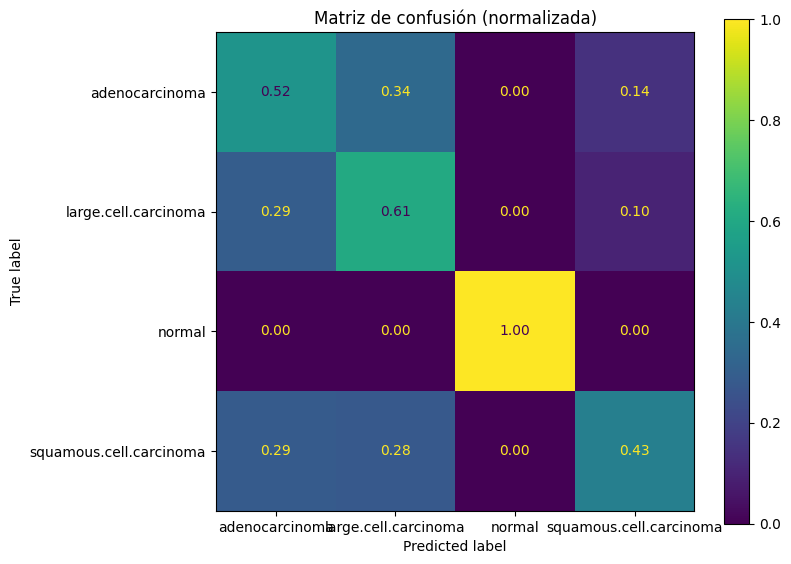

In [ ]:
from IPython.display import display
class_names = train_ds.classes
metrics_df, globales, cm =  metricas(model, test_loader, class_names)
display(metrics_df)
print(globales)
plot_cm(cm, class_names)

In [ ]:
# Guardar el modelo entrenado
torch.save(model.state_dict(), "Output/baseline_model.pth")

### Conclusiones Preliminares

Aunque las métricas globales (accuracy y F1) de validación y testeo sugieren un rendimiento bajo, el análisis one‑vs‑all y la matriz de confusión normalizada revelan que el modelo identifica de forma prácticamente perfecta las imágenes normales: la clase “normal” alcanza 1.00 en su fila y no genera falsos positivos. El error se concentra entre los subtipos de cáncer (adenocarcinoma, large cell y squamous), con confusiones cruzadas muy altas.

 Por ejemplo el 34% de adenocarcinoma se predice como large cell y 29% de squamous se reparte entre otros subtipos, lo que arrastra los promedios globales. En síntesis, el clasificador ya es muy sólido para el objetivo de “normal vs. cáncer”, pero requiere mejoras específicas para distinguir entre subtipos tumorales. Esto se condice con las conclusiones obtenidas en el analisis exploratorio de datos, donde se veia que habia relaciones muy simples y lineales entre las imagenes con y sin cancer, pero mas complejas enter los subtipos de cancer, lo que hacia la necesidad de un probar enfoques mas avanzadso como por ejemplo con mayor preprocesamiento, data augmentation, un finetuning ams complejo o hasta el uso de un modelo mas complejo o mas ciclos de entrenamiento.